In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import pickle
import glob
import re
from scipy import interpolate
import matplotlib as mpl
from matplotlib import ticker, cm
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [3]:
files = glob.glob('CLOSER/*.dat')
print(files)

['CLOSER/closer_CG_05242023_11TURNS.dat', 'CLOSER/closer_CG_05242023_10TURNS.dat', 'CLOSER/closer_CG_05242023_16TURNS.dat', 'CLOSER/closer_CG_05242023_17TURNS.dat', 'CLOSER/closer_CG_05242023_7TURNS.dat', 'CLOSER/closer_CG_05242023_6TURNS.dat', 'CLOSER/closer_CG_05242023_12TURNS.dat', 'CLOSER/closer_CG_05242023_13TURNS.dat', 'CLOSER/closer_CG_05242023_9TURNS.dat', 'CLOSER/closer_CG_05242023_8TURNS.dat', 'CLOSER/closer_CG_05242023_3TURNS.dat', 'CLOSER/closer_CG_05242023_2TURNS.dat', 'CLOSER/closer_CG_05242023_4TURNS.dat', 'CLOSER/closer_CG_05242023_5TURNS.dat', 'CLOSER/closer_CG_05242023_15TURNS.dat', 'CLOSER/closer_CG_05242023_14TURNS.dat']


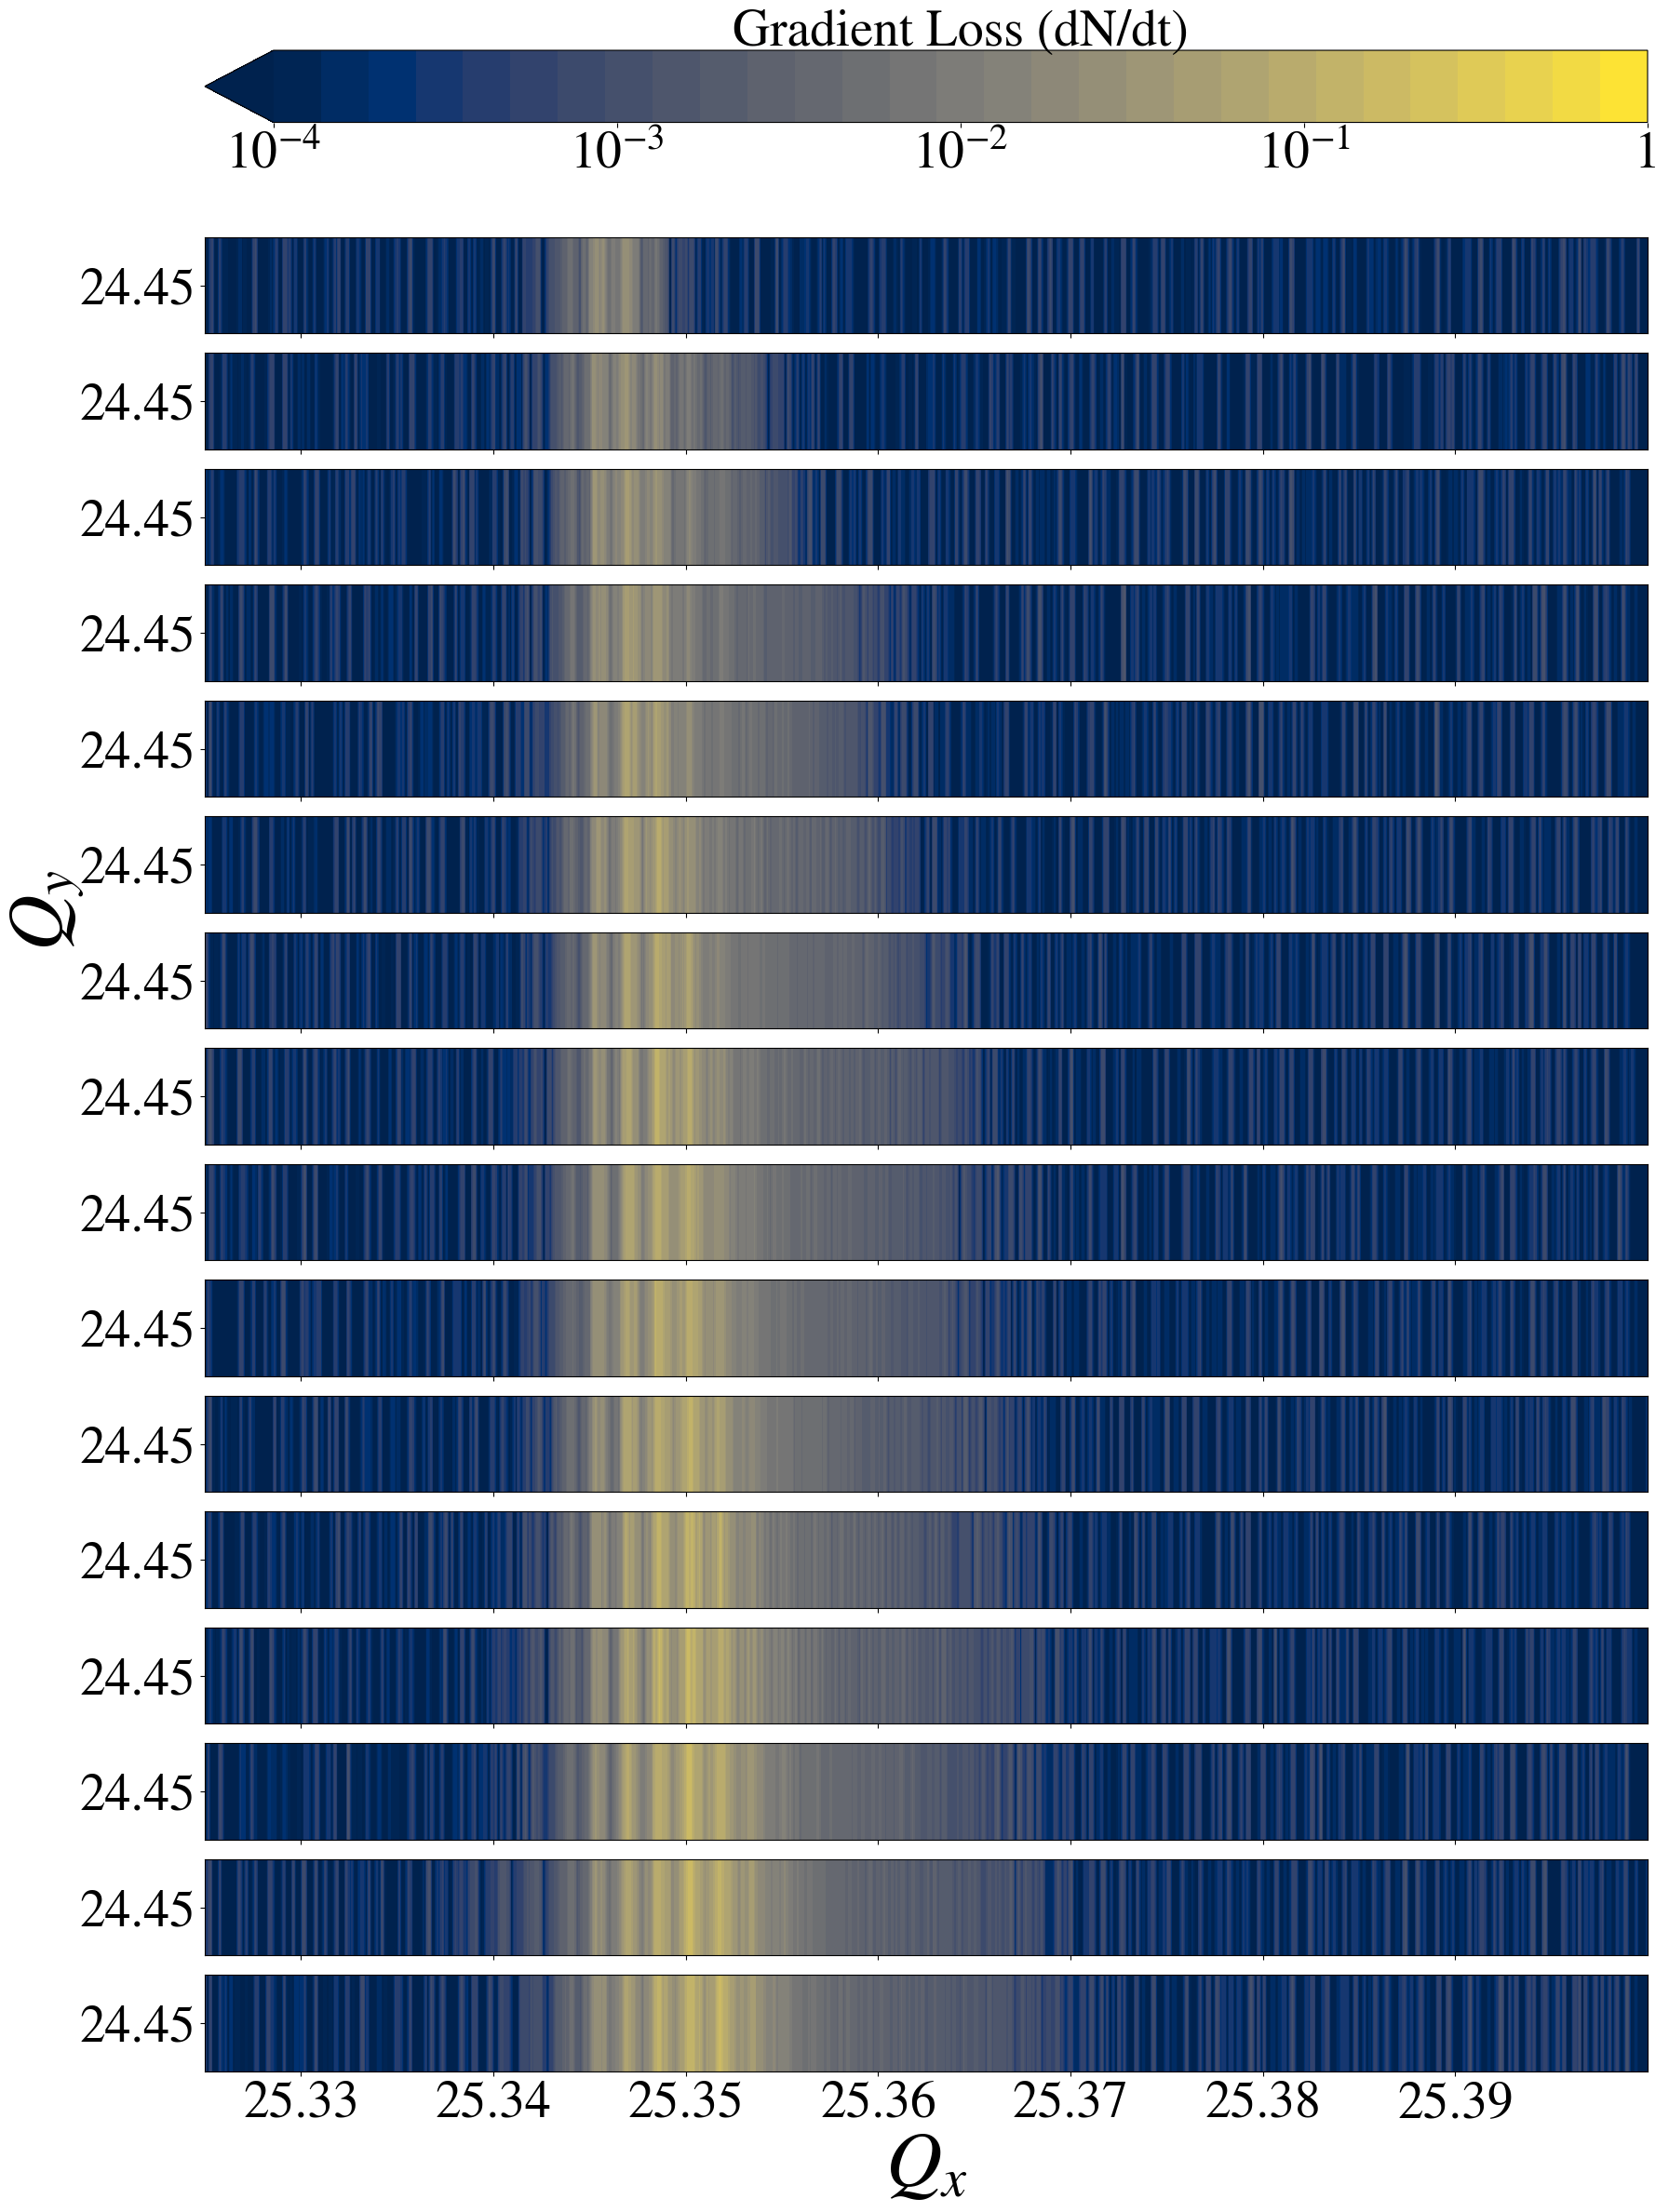

In [4]:
boosterturns = np.arange(2,18)

fig,axs=plt.subplots(len(files),1, figsize = (20,2*len(files)), sharex = True, sharey = True)

i = 0

lolim = -4
hilim = 0

levs = np.logspace(lolim,hilim,num = 30)

for boosterturnsi in boosterturns:
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)
    vtuneplot = np.linspace(0.9999*np.min(vtune),1.0001*np.max(vtune),steps)
    
    gridx,gridy = np.meshgrid(htuneplot, vtuneplot)
    rbeamplot = np.tile(-np.gradient(rbeamave)[::-1],(steps,1))
    
    for k in range(rbeamplot.shape[0]):
        rbeamplot[k,rbeamplot[k,:]<=0]=10**lolim
    
    cf = axs[i].contourf(gridx,gridy,rbeamplot,locator=ticker.LogLocator(numticks=10),
                         levels=levs,cmap = 'cividis',extend = 'min')
    #axs[i].plot(timeave,np.gradient(rbeamave))
    
    totalrbeam = np.max(rbeamave)*10e12
    ppb = totalrbeam/81
    #axs[i].set_title('BOOSTER TURNS=%d, R:BEAM=%.3e, PPB=%.3e'%(boosterturnsi,totalrbeam,ppb),fontsize = 28)
    
    axs[i].set_yticks([24.45])
    axs[i].set_yticklabels([r'24.45'],fontsize = 40)
    
    axs[i].tick_params(axis='x', labelsize=40)
    #axs[i].label_outer()
    
    i=i+1

plt.xlabel('$Q_x$',fontsize=60)
fig.supylabel('$Q_y$',fontsize=60)    

#cbar = fig.colorbar(cf, ticks=np.logspace(-4,0,num = 5))    
cbar = fig.colorbar(cf, ax=axs.ravel().tolist(), ticks=np.logspace(lolim,hilim,num = 5), 
                    orientation = 'horizontal', location = 'top', ticklocation = 'bottom')

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'1'],fontsize = 40)
#cbar.ax.tick_params(axis='x', top=False, labeltop=True, bottom=True, labelbottom=False)
cbar.ax.set_xlabel('Gradient Loss (dN/dt)', fontsize = 40)

for ax in axs:
    ax.label_outer()

fig.patch.set_facecolor('white')
#plt.tight_layout()
plt.show()
plt.close()

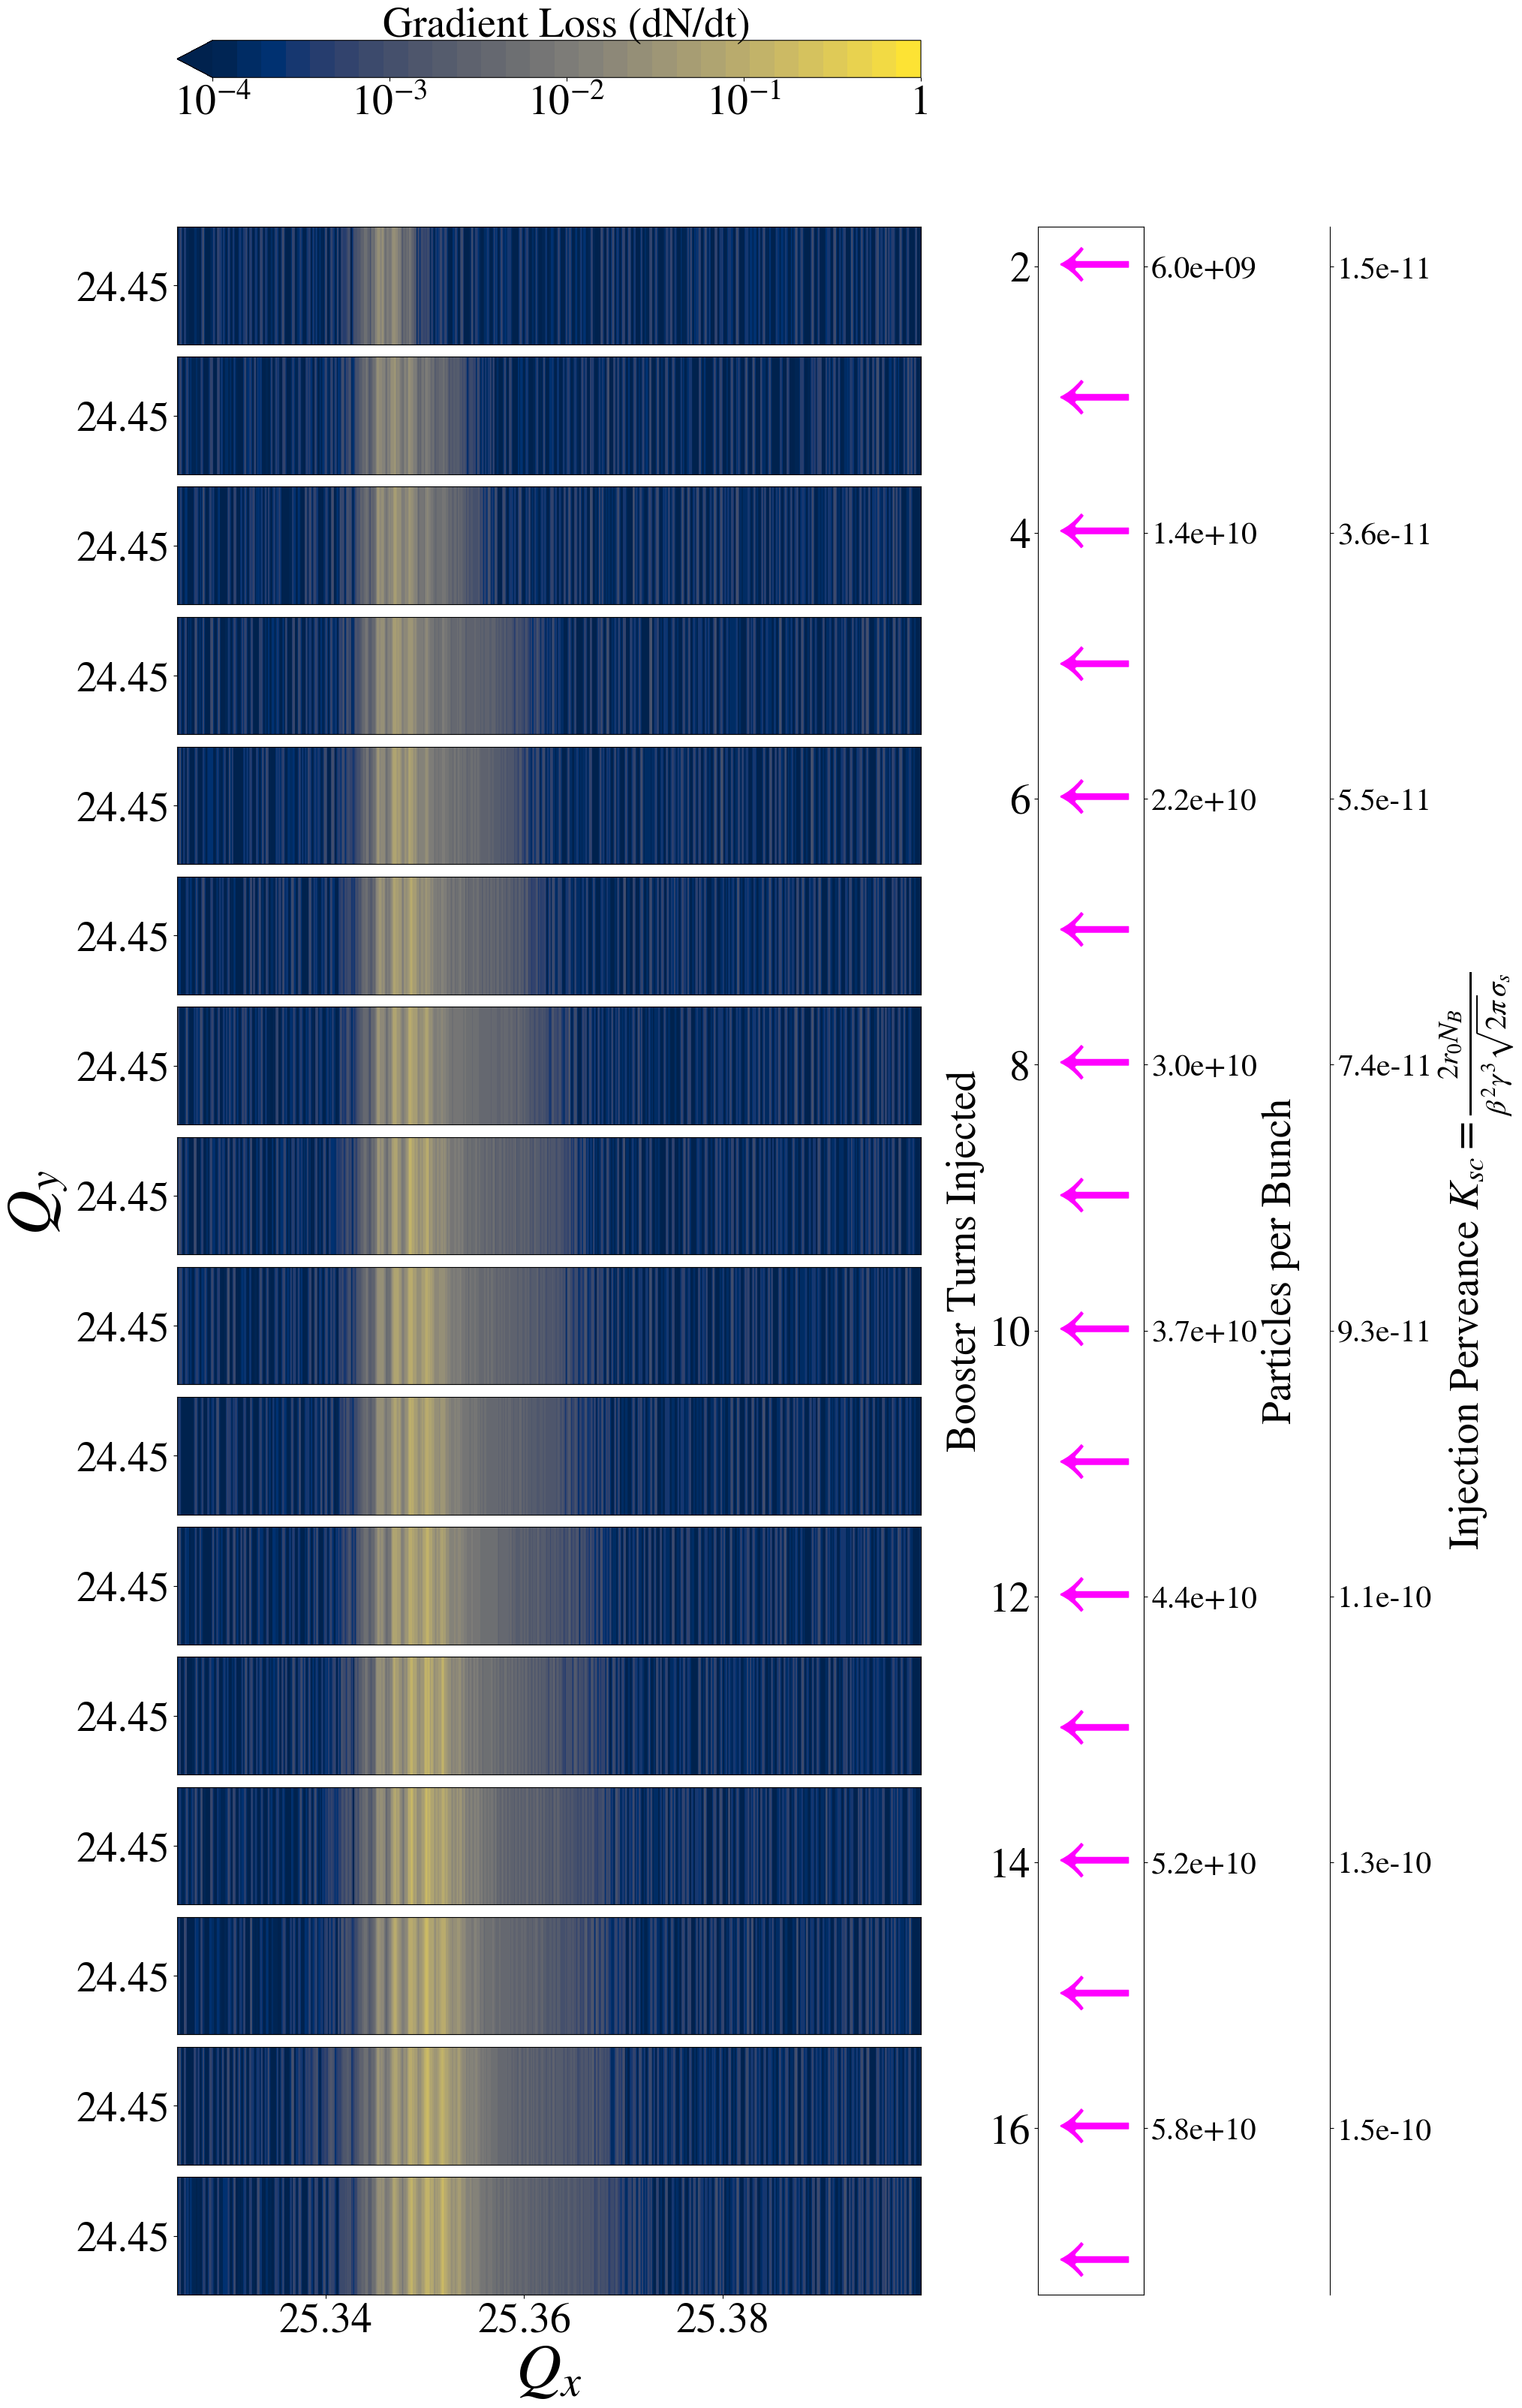

In [5]:
from matplotlib.gridspec import GridSpec
boosterturns = np.arange(2,18)

fig = plt.figure(layout="constrained",figsize = (20,2*len(files)))

gs = GridSpec(len(files),2, figure=fig, width_ratios = [7,1])
#fig, axs = plt.subplots(ncols=2, nrows=len(files), figsize = (20,2*len(files)), width_ratios=[3, 1.])

i = 0

lolim = -4
hilim = 0

levs = np.logspace(lolim,hilim,num = 30)
axs = []

ppbs = []

for boosterturnsi in boosterturns:
    
    ax = fig.add_subplot(gs[i,0])
    axs.append(ax)
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)
    vtuneplot = np.linspace(0.9999*np.min(vtune),1.0001*np.max(vtune),steps)
    
    gridx,gridy = np.meshgrid(htuneplot, vtuneplot)
    rbeamplot = np.tile(-np.gradient(rbeamave)[::-1],(steps,1))
    
    for k in range(rbeamplot.shape[0]):
        rbeamplot[k,rbeamplot[k,:]<=0]=10**lolim
    
    cf = axs[i].contourf(gridx,gridy,rbeamplot,locator=ticker.LogLocator(numticks=10),
                         levels=levs,cmap = 'cividis',extend = 'min')
    #axs[i].plot(timeave,np.gradient(rbeamave))
    
    totalrbeam = np.max(rbeamave)*1e12
    ppb = totalrbeam/81
    ppbs.append(ppb)
    #axs[i].set_title('BOOSTER TURNS=%d, R:BEAM=%.3e, PPB=%.3e'%(boosterturnsi,totalrbeam,ppb),fontsize = 28)
    
    axs[i].set_yticks([24.45])
    axs[i].set_yticklabels([r'24.45'],fontsize = 40)
    
    axs[i].tick_params(axis='x', labelsize=40)
    #axs[i].label_outer()
    
    if boosterturnsi != boosterturns[-1]:
        axs[i].get_xaxis().set_ticks([])
    #frame1.axes.get_yaxis().set_ticks([])
    
    i=i+1

plt.xlabel('$Q_x$',fontsize=60)
fig.supylabel('$Q_y$',fontsize=60)    

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#cbar = fig.colorbar(cf, ticks=np.logspace(-4,0,num = 5))    
cbar = fig.colorbar(cf, ax=np.array(axs).ravel().tolist(), ticks=np.logspace(lolim,hilim,num = 5), 
                    orientation = 'horizontal', location = 'top', ticklocation = 'bottom')

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'1'],fontsize = 40)
#cbar.ax.tick_params(axis='x', top=False, labeltop=True, bottom=True, labelbottom=False)
cbar.ax.set_xlabel('Gradient Loss (dN/dt)', fontsize = 40)

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
axright = fig.add_subplot(gs[:,1])
axright.scatter(np.zeros(len(boosterturns)),boosterturns, marker=r'$\leftarrow$', c = 'fuchsia', s=5000)

axright.set_ylim(1.7,17.25)
axright.get_xaxis().set_ticks([])

axright.invert_yaxis()
axright.tick_params(axis='y', labelsize=40)

axright.set_ylabel('Booster Turns Injected', fontsize = 40)

fun1 = interpolate.interp1d(boosterturns,ppbs,fill_value='extrapolate')
fun1inv = interpolate.interp1d(ppbs,boosterturns,fill_value='extrapolate')
twin1 = axright.secondary_yaxis('right',functions=(fun1,fun1inv))

kscs = (2*1.5346983e-18/(0.99**2*9.529**3*(2*np.pi)**0.5*0.5726))*np.array(ppbs)
fun2 = interpolate.interp1d(boosterturns,kscs,fill_value='extrapolate')
fun2inv = interpolate.interp1d(kscs,boosterturns,fill_value='extrapolate')
twin2 = axright.secondary_yaxis(2.75,functions=(fun2,fun2inv))

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin1.spines.right.set_position(("axes", 1.2))
#twin2.spines.right.set_position(("axes", 3))

twin1.tick_params(axis='y', labelsize=30)
twin2.tick_params(axis='y', labelsize=30)

#twin1.scatter(np.zeros(len(ppbs)),ppbs)
twin1.set_ylabel('Particles per Bunch', fontsize = 40)
twin1.set_yticks(ppbs[::2])
twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin1.invert_yaxis()

twin2.set_ylabel(r'Injection Perveance $K_{sc}=\frac{2r_0 N_B}{\beta ^2 \gamma ^3 \sqrt{2 \pi} \sigma_s}$', fontsize = 40)
twin2.set_yticks(kscs[::2])
twin2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin2.invert_yaxis()

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

fig.patch.set_facecolor('white')
#plt.tight_layout()
plt.show()
plt.close()

/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/1122494277.py:76: RuntimeWarning: divide by zero encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/1122494277.py:76: RuntimeWarning: invalid value encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))


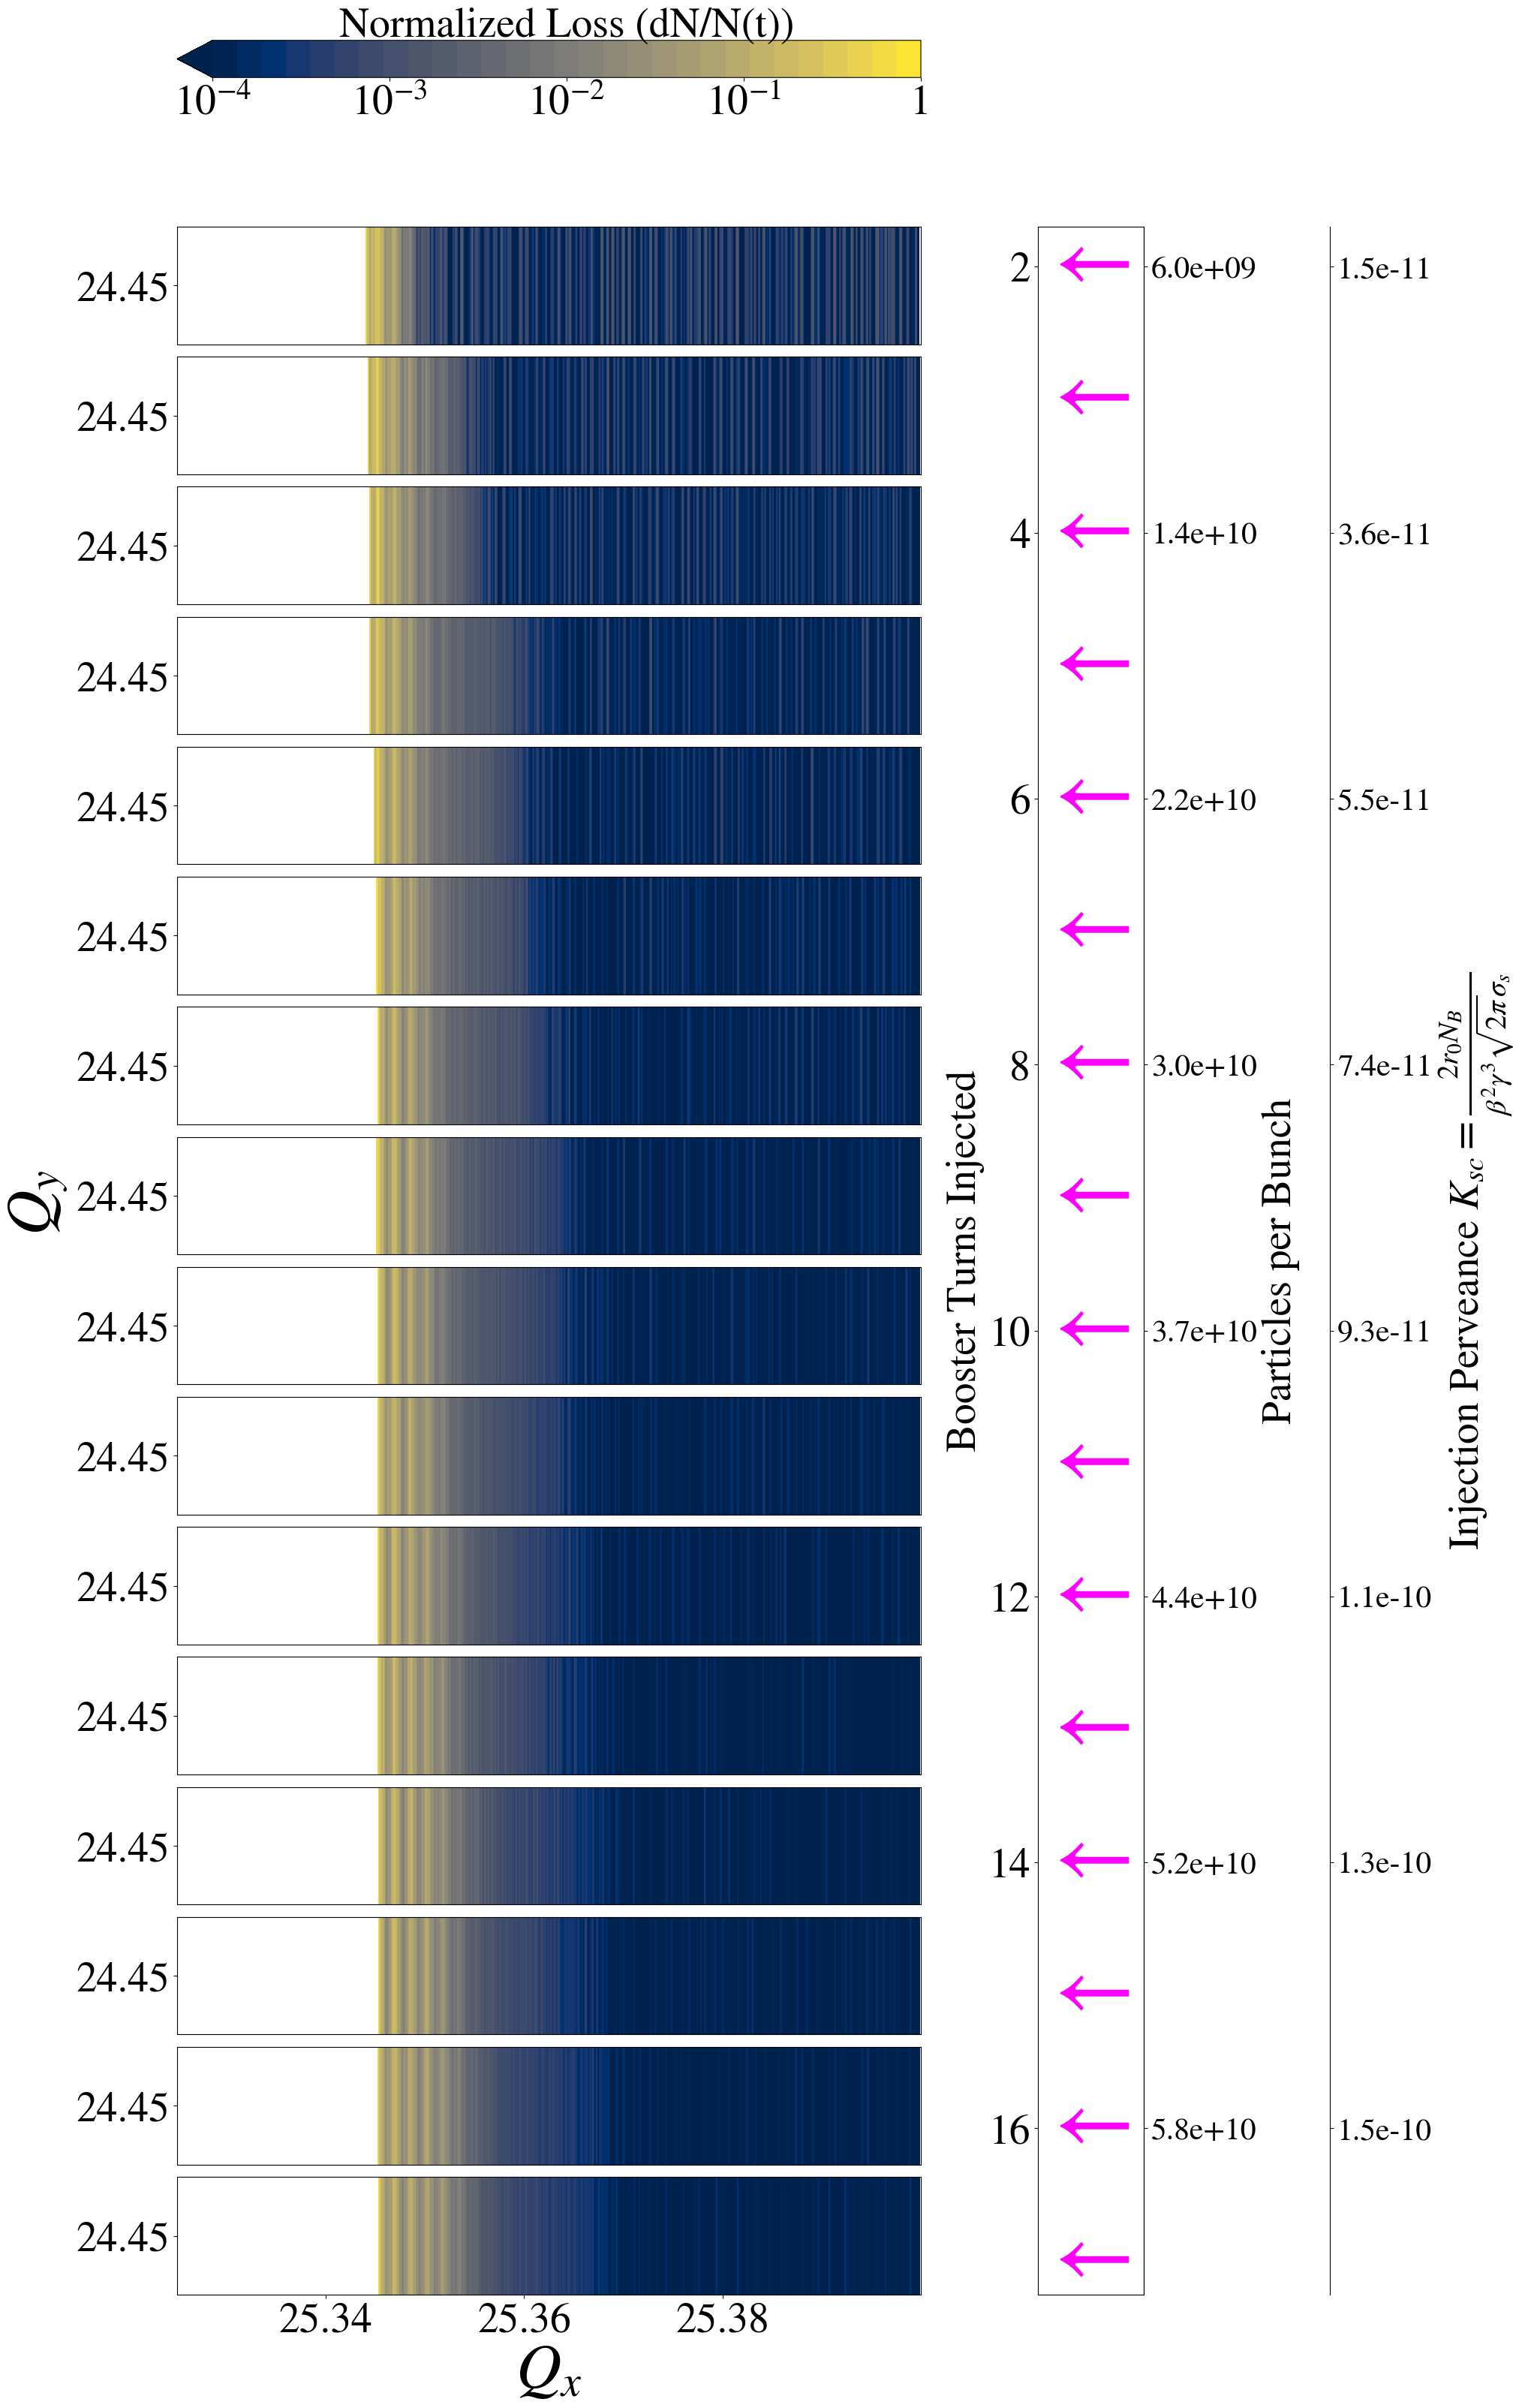

In [6]:
boosterturns = np.arange(2,18)

fig = plt.figure(layout="constrained",figsize = (20,2*len(files)))

gs = GridSpec(len(files),2, figure=fig, width_ratios = [7,1])
#fig, axs = plt.subplots(ncols=2, nrows=len(files), figsize = (20,2*len(files)), width_ratios=[3, 1.])

i = 0

lolim = -4
hilim = 0

levs = np.logspace(lolim,hilim,num = 30)
axs = []

ppbs = []

for boosterturnsi in boosterturns:
    
    ax = fig.add_subplot(gs[i,0])
    axs.append(ax)
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    rbeamave[rbeamave<0.02*np.max(rbeamave)] = 0
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)
    vtuneplot = np.linspace(0.9999*np.min(vtune),1.0001*np.max(vtune),steps)
    
    gridx,gridy = np.meshgrid(htuneplot, vtuneplot)
    rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
    
    for k in range(rbeamplot.shape[0]):
        rbeamplot[k,rbeamplot[k,:]<=0]=10**lolim
    
    cf = axs[i].contourf(gridx,gridy,rbeamplot,locator=ticker.LogLocator(numticks=10),
                         levels=levs,cmap = 'cividis',extend = 'min')
    #axs[i].plot(timeave,np.gradient(rbeamave))
    
    totalrbeam = np.max(rbeamave)*1e12
    ppb = totalrbeam/81
    ppbs.append(ppb)
    #axs[i].set_title('BOOSTER TURNS=%d, R:BEAM=%.3e, PPB=%.3e'%(boosterturnsi,totalrbeam,ppb),fontsize = 28)
    
    axs[i].set_yticks([24.45])
    axs[i].set_yticklabels([r'24.45'],fontsize = 40)
    
    axs[i].tick_params(axis='x', labelsize=40)
    #axs[i].label_outer()
    
    if boosterturnsi != boosterturns[-1]:
        axs[i].get_xaxis().set_ticks([])
    #frame1.axes.get_yaxis().set_ticks([])
    
    i=i+1

plt.xlabel('$Q_x$',fontsize=60)
fig.supylabel('$Q_y$',fontsize=60)    

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#cbar = fig.colorbar(cf, ticks=np.logspace(-4,0,num = 5))    
cbar = fig.colorbar(cf, ax=np.array(axs).ravel().tolist(), ticks=np.logspace(lolim,hilim,num = 5), 
                    orientation = 'horizontal', location = 'top', ticklocation = 'bottom')

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'1'],fontsize = 40)
#cbar.ax.tick_params(axis='x', top=False, labeltop=True, bottom=True, labelbottom=False)
cbar.ax.set_xlabel('Normalized Loss (dN/N(t))', fontsize = 40)

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
axright = fig.add_subplot(gs[:,1])
axright.scatter(np.zeros(len(boosterturns)),boosterturns, marker=r'$\leftarrow$', c = 'fuchsia', s=5000)

axright.set_ylim(1.7,17.25)
axright.get_xaxis().set_ticks([])

axright.invert_yaxis()
axright.tick_params(axis='y', labelsize=40)

axright.set_ylabel('Booster Turns Injected', fontsize = 40)

fun1 = interpolate.interp1d(boosterturns,ppbs,fill_value='extrapolate')
fun1inv = interpolate.interp1d(ppbs,boosterturns,fill_value='extrapolate')
twin1 = axright.secondary_yaxis('right',functions=(fun1,fun1inv))

kscs = (2*1.5346983e-18/(0.99**2*9.529**3*(2*np.pi)**0.5*0.5726))*np.array(ppbs)
fun2 = interpolate.interp1d(boosterturns,kscs,fill_value='extrapolate')
fun2inv = interpolate.interp1d(kscs,boosterturns,fill_value='extrapolate')
twin2 = axright.secondary_yaxis(2.75,functions=(fun2,fun2inv))

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin1.spines.right.set_position(("axes", 1.2))
#twin2.spines.right.set_position(("axes", 3))

twin1.tick_params(axis='y', labelsize=30)
twin2.tick_params(axis='y', labelsize=30)

#twin1.scatter(np.zeros(len(ppbs)),ppbs)
twin1.set_ylabel('Particles per Bunch', fontsize = 40)
twin1.set_yticks(ppbs[::2])
twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin1.invert_yaxis()

twin2.set_ylabel(r'Injection Perveance $K_{sc}=\frac{2r_0 N_B}{\beta ^2 \gamma ^3 \sqrt{2 \pi} \sigma_s}$', fontsize = 40)
twin2.set_yticks(kscs[::2])
twin2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin2.invert_yaxis()

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

fig.patch.set_facecolor('white')
#plt.tight_layout()
plt.show()
plt.close()

/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/3960365515.py:77: RuntimeWarning: divide by zero encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/3960365515.py:77: RuntimeWarning: invalid value encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))


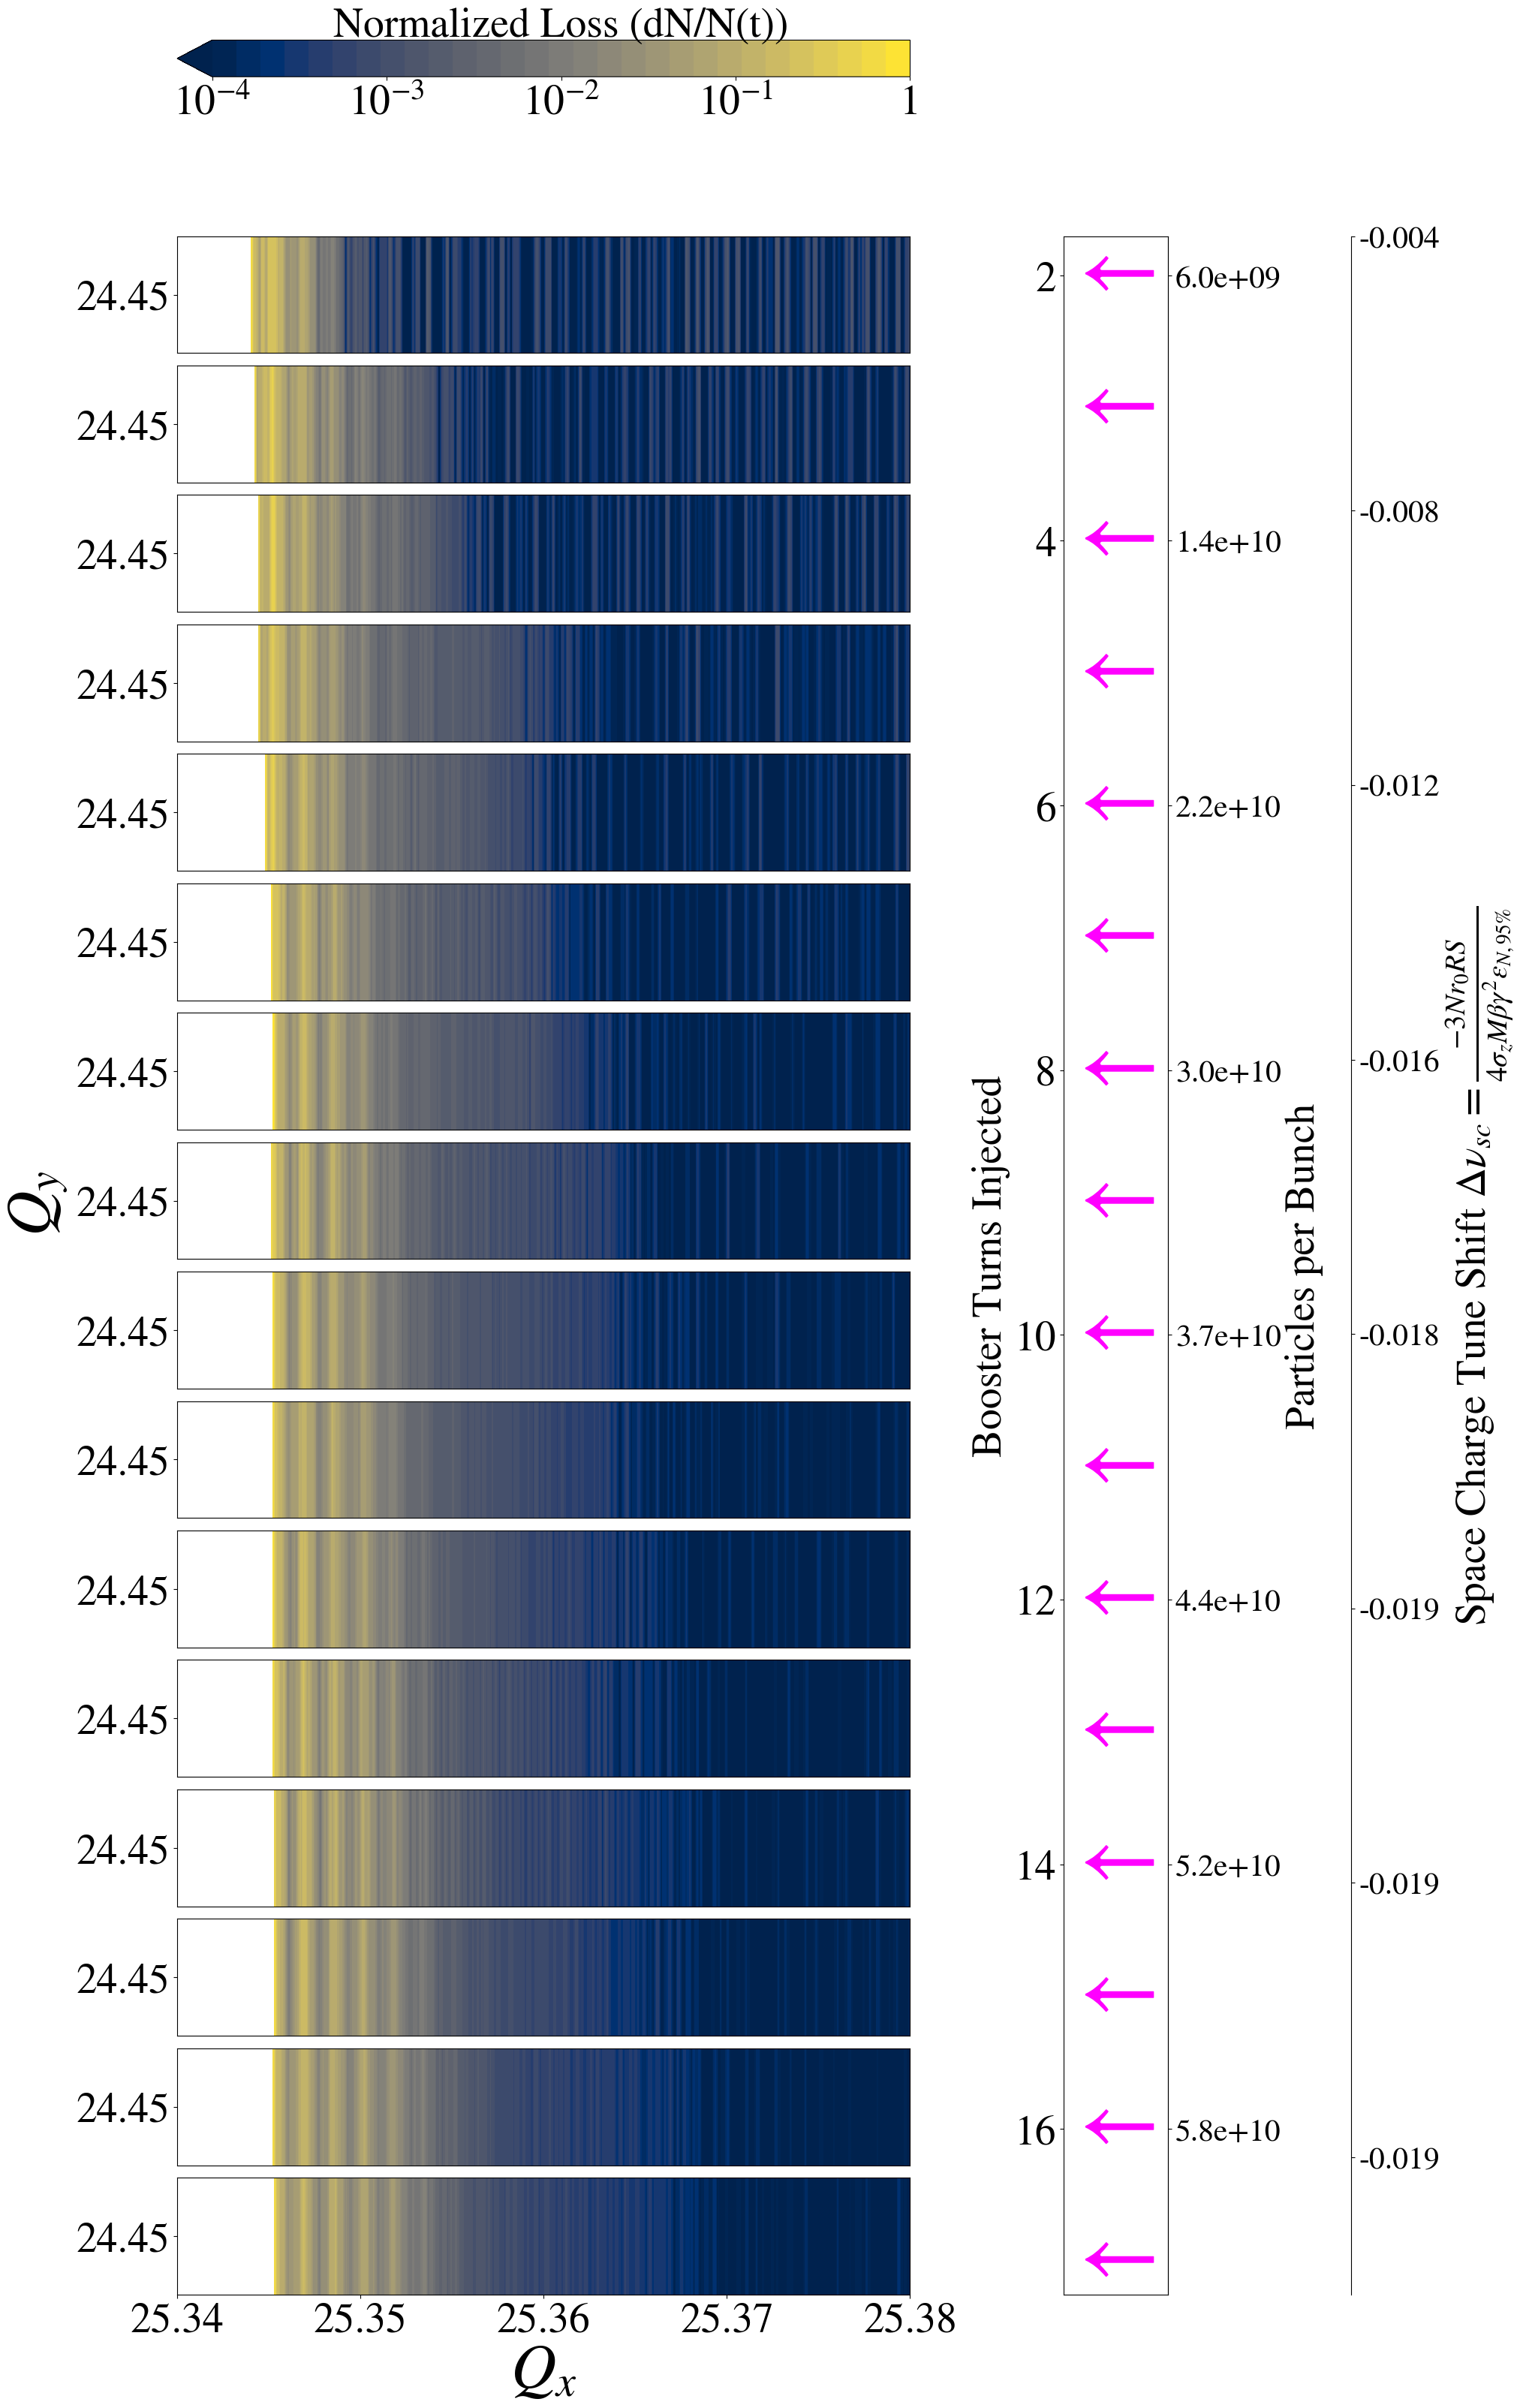

In [7]:
boosterturns = np.arange(2,18)

fig = plt.figure(layout="constrained",figsize = (20,2*len(files)))
fig.set_dpi(100)

gs = GridSpec(len(files),2, figure=fig, width_ratios = [7,1])
#fig, axs = plt.subplots(ncols=2, nrows=len(files), figsize = (20,2*len(files)), width_ratios=[3, 1.])

i = 0

lolim = -4
hilim = 0

levs = np.logspace(lolim,hilim,num = 30)
axs = []

ppbs = []

for boosterturnsi in boosterturns:
    
    ax = fig.add_subplot(gs[i,0])
    axs.append(ax)
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    rbeamave[rbeamave<0.02*np.max(rbeamave)] = 0
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)
    vtuneplot = np.linspace(0.9999*np.min(vtune),1.0001*np.max(vtune),steps)
    
    gridx,gridy = np.meshgrid(htuneplot, vtuneplot)
    rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
    
    for k in range(rbeamplot.shape[0]):
        rbeamplot[k,rbeamplot[k,:]<=0]=10**lolim
    
    cf = axs[i].contourf(gridx,gridy,rbeamplot,locator=ticker.LogLocator(numticks=10),
                         levels=levs,cmap = 'cividis',extend = 'min')
    #axs[i].plot(timeave,np.gradient(rbeamave))
    
    totalrbeam = np.max(rbeamave)*1e12
    ppb = totalrbeam/81
    ppbs.append(ppb)
    #axs[i].set_title('BOOSTER TURNS=%d, R:BEAM=%.3e, PPB=%.3e'%(boosterturnsi,totalrbeam,ppb),fontsize = 28)
    
    axs[i].set_yticks([24.45])
    axs[i].set_yticklabels([r'24.45'],fontsize = 40)
    
    axs[i].tick_params(axis='x', labelsize=40)
    #axs[i].label_outer()
    
    if boosterturnsi != boosterturns[-1]:
        axs[i].get_xaxis().set_ticks([])
    #frame1.axes.get_yaxis().set_ticks([])
    axs[i].set_xlim(25.34,25.38)
    
    i=i+1

plt.xlabel('$Q_x$',fontsize=60)
fig.supylabel('$Q_y$',fontsize=60)    

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#cbar = fig.colorbar(cf, ticks=np.logspace(-4,0,num = 5))    
cbar = fig.colorbar(cf, ax=np.array(axs).ravel().tolist(), ticks=np.logspace(lolim,hilim,num = 5), 
                    orientation = 'horizontal', location = 'top', ticklocation = 'bottom')

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'1'],fontsize = 40)
#cbar.ax.tick_params(axis='x', top=False, labeltop=True, bottom=True, labelbottom=False)
cbar.ax.set_xlabel('Normalized Loss (dN/N(t))', fontsize = 40)

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
axright = fig.add_subplot(gs[:,1])
axright.scatter(np.zeros(len(boosterturns)),boosterturns, marker=r'$\leftarrow$', c = 'fuchsia', s=5000)

axright.set_ylim(1.7,17.25)
axright.get_xaxis().set_ticks([])

axright.invert_yaxis()
axright.tick_params(axis='y', labelsize=40)

axright.set_ylabel('Booster Turns Injected', fontsize = 40)

fun1 = interpolate.interp1d(boosterturns,ppbs,fill_value='extrapolate')
fun1inv = interpolate.interp1d(ppbs,boosterturns,fill_value='extrapolate')
twin1 = axright.secondary_yaxis('right',functions=(fun1,fun1inv))

# r0 = 1.53469827e-18
# mproton = 938.2720813e6
# totalenergy = ((8.835e9)**2+(mproton)**2)**0.5
# gamma = totalenergy/mproton
# beta = np.sqrt(1-(1/gamma)**2)
# radius = 3319.4/(2*np.pi)
# S = 1.596
# sigmaz = 0.5726
# M = 81

databetiay = pandas.read_csv('emittancexy.csv',index_col=0)
databetiay = databetiay[databetiay['tuneshiftx']>-0.5]
databetiay = databetiay[databetiay['tuneshifty']>-0.5]

fun2 = interpolate.interp1d(databetiay['booster_turns'],databetiay['tuneshiftx'],kind='nearest',fill_value='extrapolate')
fun2inv = interpolate.interp1d(databetiay['tuneshiftx'],databetiay['booster_turns'],kind='nearest',fill_value='extrapolate')
twin2 = axright.secondary_yaxis(2.75,functions=(fun2,fun2inv))

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin1.spines.right.set_position(("axes", 1.2))
#twin2.spines.right.set_position(("axes", 3))

twin1.tick_params(axis='y', labelsize=30)
twin2.tick_params(axis='y', labelsize=30)

#twin1.scatter(np.zeros(len(ppbs)),ppbs)
twin1.set_ylabel('Particles per Bunch', fontsize = 40)
twin1.set_yticks(ppbs[::2])
twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin1.invert_yaxis()

twin2.set_ylabel(r'Space Charge Tune Shift $\Delta \nu_{sc}=\frac{-3 N r_0 R S}{4 \sigma_z M \beta \gamma ^2 \varepsilon_{N,95\%}}$', fontsize = 40)
twin2.set_yticks(fun2(boosterturns)[::2])
twin2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
twin2.invert_yaxis()

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

fig.patch.set_facecolor('white')
#plt.tight_layout()
plt.show()
plt.close()

/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/2889735702.py:77: RuntimeWarning: divide by zero encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
/var/folders/42/7sv6hz7577n5zy69jc4nkh300000gn/T/ipykernel_91745/2889735702.py:77: RuntimeWarning: invalid value encountered in divide
  rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))


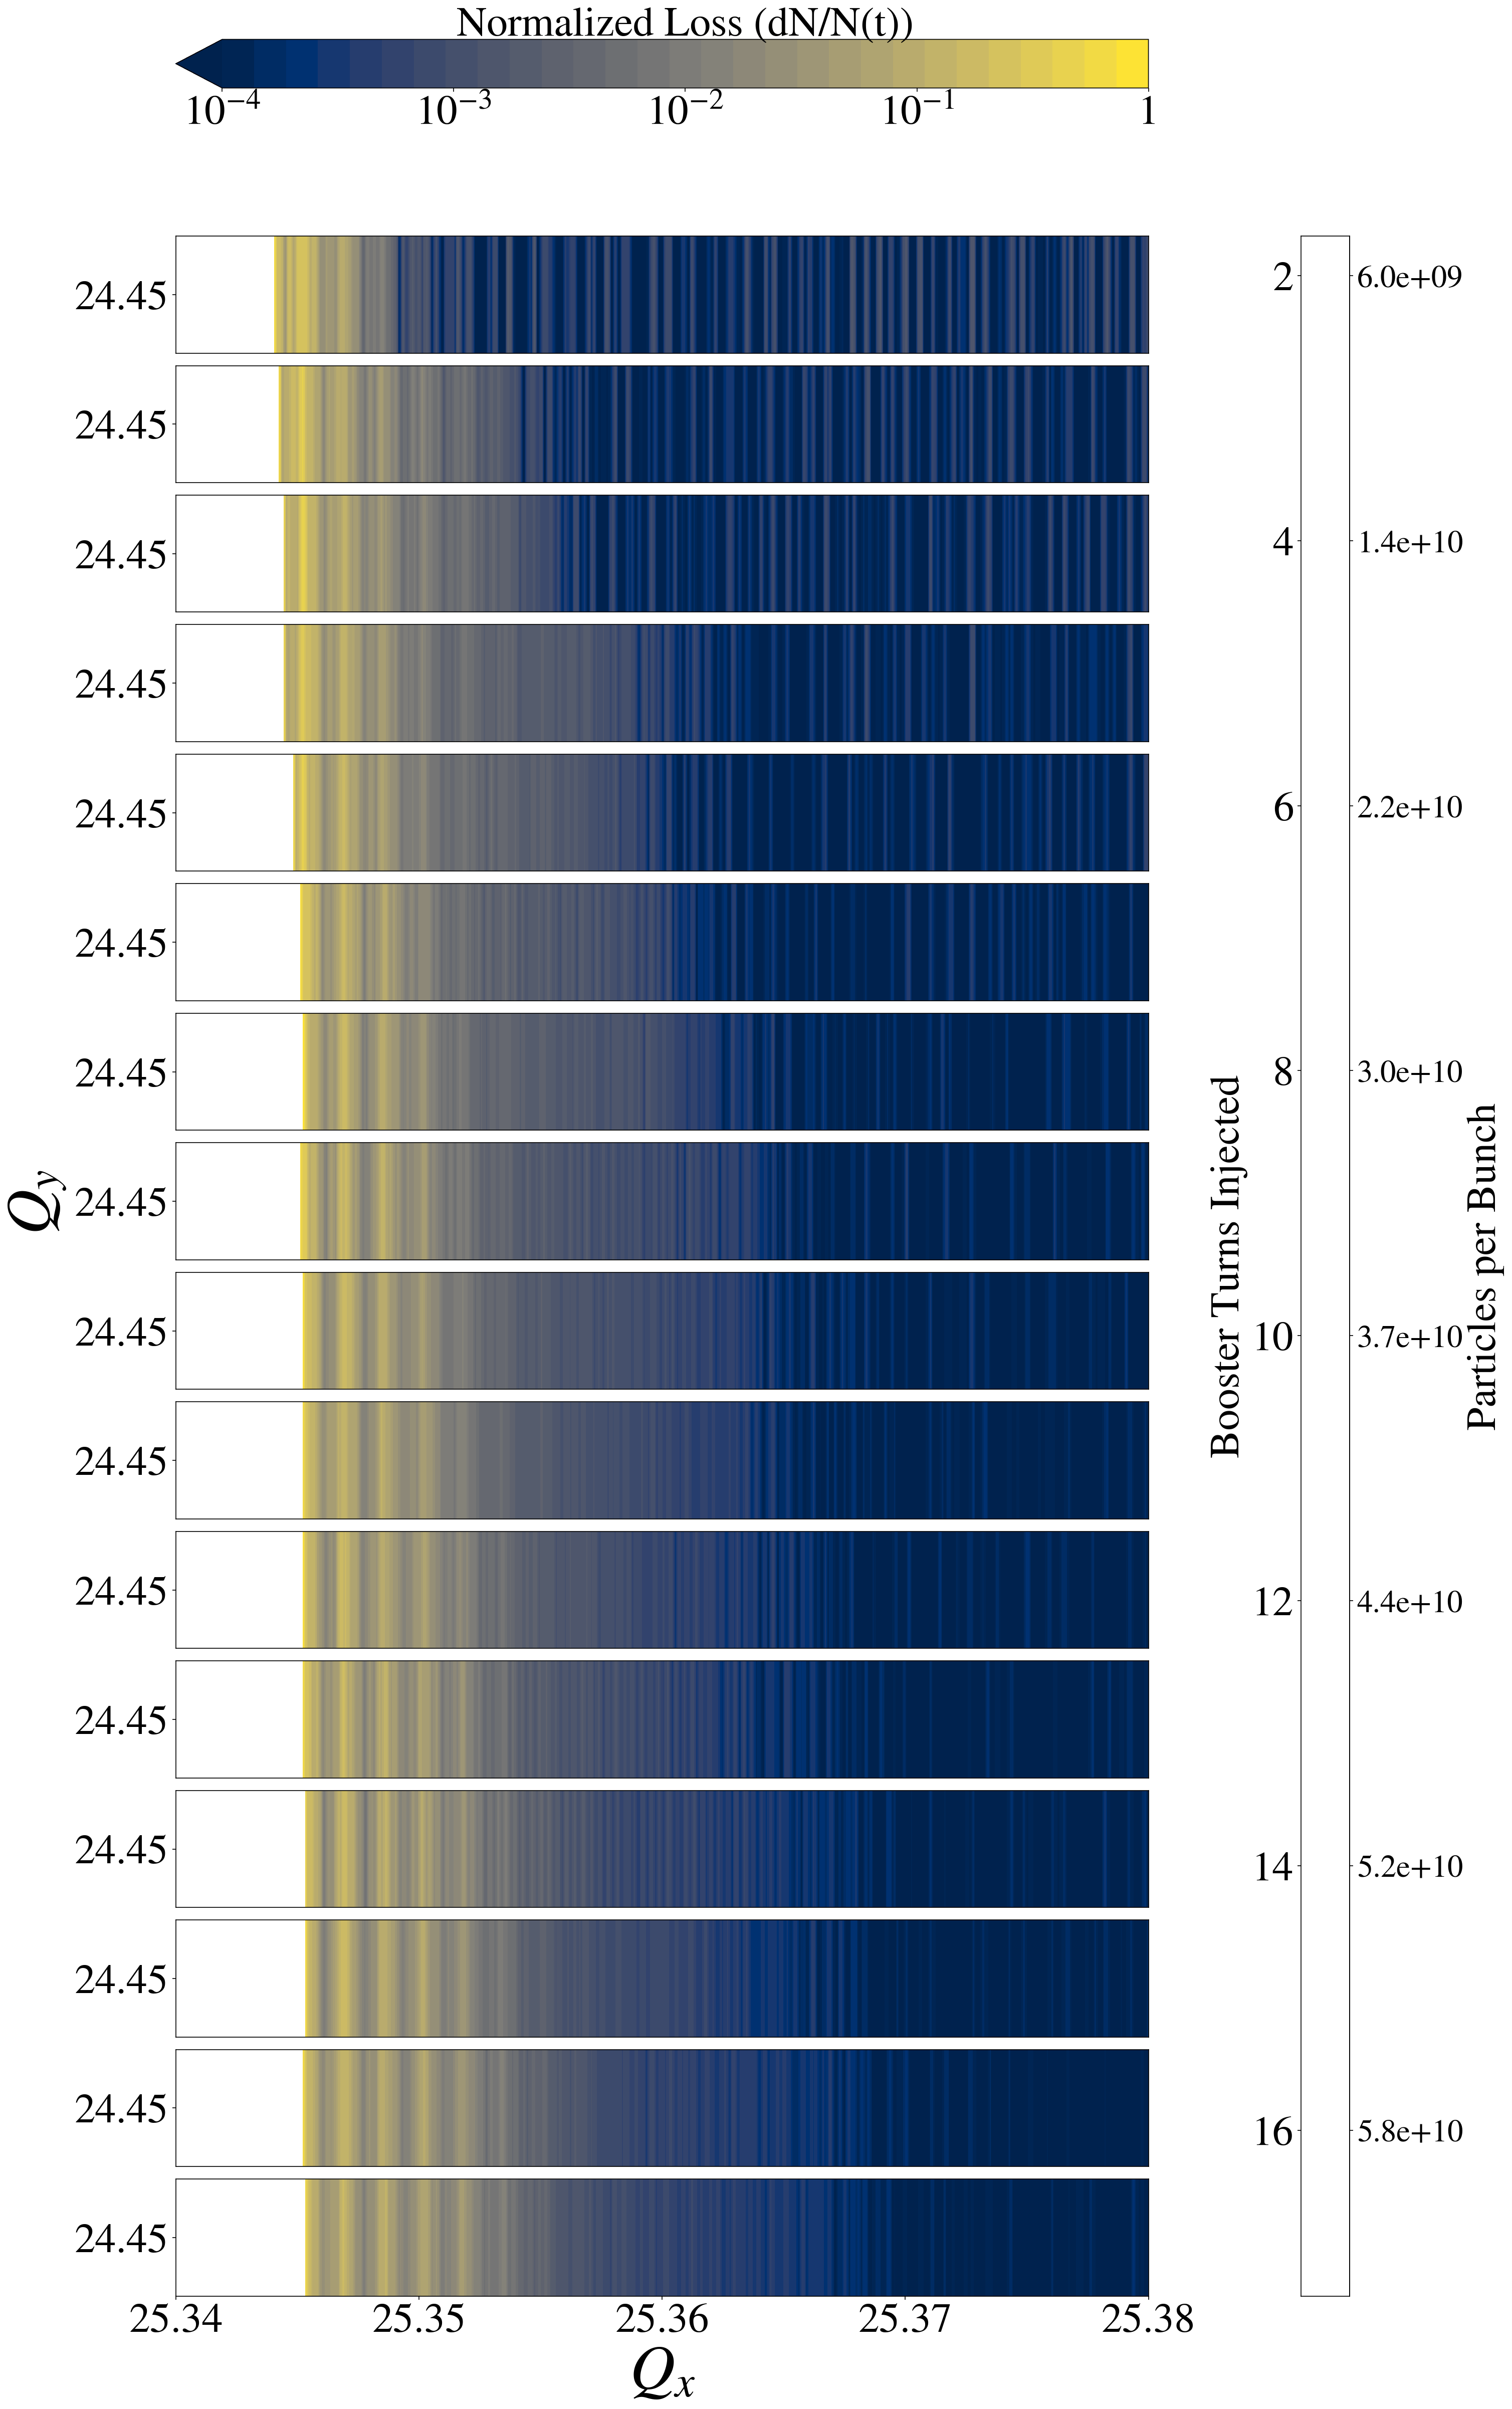

In [8]:
boosterturns = np.arange(2,18)

fig = plt.figure(layout="constrained",figsize = (20,2*len(files)))
fig.set_dpi(150)

gs = GridSpec(len(files),2, figure=fig, width_ratios = [20,1])
#fig, axs = plt.subplots(ncols=2, nrows=len(files), figsize = (20,2*len(files)), width_ratios=[3, 1.])

i = 0

lolim = -4
hilim = 0

levs = np.logspace(lolim,hilim,num = 30)
axs = []

ppbs = []

for boosterturnsi in boosterturns:
    
    ax = fig.add_subplot(gs[i,0])
    axs.append(ax)
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    rbeamave[rbeamave<0.02*np.max(rbeamave)] = 0
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)
    vtuneplot = np.linspace(0.9999*np.min(vtune),1.0001*np.max(vtune),steps)
    
    gridx,gridy = np.meshgrid(htuneplot, vtuneplot)
    rbeamplot = np.tile(-np.divide(np.gradient(rbeamave)[::-1],rbeamave[::-1]),(steps,1))
    
    for k in range(rbeamplot.shape[0]):
        rbeamplot[k,rbeamplot[k,:]<=0]=10**lolim
    
    cf = axs[i].contourf(gridx,gridy,rbeamplot,locator=ticker.LogLocator(numticks=10),
                         levels=levs,cmap = 'cividis',extend = 'min')
    #axs[i].plot(timeave,np.gradient(rbeamave))
    
    totalrbeam = np.max(rbeamave)*1e12
    ppb = totalrbeam/81
    ppbs.append(ppb)
    #axs[i].set_title('BOOSTER TURNS=%d, R:BEAM=%.3e, PPB=%.3e'%(boosterturnsi,totalrbeam,ppb),fontsize = 28)
    
    axs[i].set_yticks([24.45])
    axs[i].set_yticklabels([r'24.45'],fontsize = 40)
    
    axs[i].tick_params(axis='x', labelsize=40)
    #axs[i].label_outer()
    
    if boosterturnsi != boosterturns[-1]:
        axs[i].get_xaxis().set_ticks([])
    #frame1.axes.get_yaxis().set_ticks([])
    axs[i].set_xlim(25.34,25.38)
    
    i=i+1

plt.xlabel('$Q_x$',fontsize=60)
fig.supylabel('$Q_y$',fontsize=60)    

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#cbar = fig.colorbar(cf, ticks=np.logspace(-4,0,num = 5))    
cbar = fig.colorbar(cf, ax=np.array(axs).ravel().tolist(), ticks=np.logspace(lolim,hilim,num = 5), 
                    orientation = 'horizontal', location = 'top', ticklocation = 'bottom')

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'1'],fontsize = 40)
#cbar.ax.tick_params(axis='x', top=False, labeltop=True, bottom=True, labelbottom=False)
cbar.ax.set_xlabel('Normalized Loss (dN/N(t))', fontsize = 40)

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
axright = fig.add_subplot(gs[:,1])
#axright.scatter(np.zeros(len(boosterturns)),boosterturns, marker=r'$\leftarrow$', c = 'fuchsia', s=5000)

axright.set_ylim(1.7,17.25)
axright.get_xaxis().set_ticks([])

axright.invert_yaxis()
axright.tick_params(axis='y', labelsize=40)

axright.set_ylabel('Booster Turns Injected', fontsize = 40)

fun1 = interpolate.interp1d(boosterturns,ppbs,fill_value='extrapolate')
fun1inv = interpolate.interp1d(ppbs,boosterturns,fill_value='extrapolate')
twin1 = axright.secondary_yaxis('right',functions=(fun1,fun1inv))

# r0 = 1.53469827e-18
# mproton = 938.2720813e6
# totalenergy = ((8.835e9)**2+(mproton)**2)**0.5
# gamma = totalenergy/mproton
# beta = np.sqrt(1-(1/gamma)**2)
# radius = 3319.4/(2*np.pi)
# S = 1.596
# sigmaz = 0.5726
# M = 81

databetiay = pandas.read_csv('emittancexy.csv',index_col=0)
databetiay = databetiay[databetiay['tuneshiftx']>-0.5]
databetiay = databetiay[databetiay['tuneshifty']>-0.5]

fun2 = interpolate.interp1d(databetiay['booster_turns'],databetiay['tuneshiftx'],kind='nearest',fill_value='extrapolate')
fun2inv = interpolate.interp1d(databetiay['tuneshiftx'],databetiay['booster_turns'],kind='nearest',fill_value='extrapolate')
# twin2 = axright.secondary_yaxis(2.75,functions=(fun2,fun2inv))

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin1.spines.right.set_position(("axes", 1.2))
#twin2.spines.right.set_position(("axes", 3))

twin1.tick_params(axis='y', labelsize=30)
# twin2.tick_params(axis='y', labelsize=30)

#twin1.scatter(np.zeros(len(ppbs)),ppbs)
twin1.set_ylabel('Particles per Bunch', fontsize = 40)
twin1.set_yticks(ppbs[::2])
twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
twin1.invert_yaxis()

# twin2.set_ylabel(r'Space Charge Tune Shift $\Delta \nu_{sc}=\frac{-3 N r_0 R S}{4 \sigma_z M \beta \gamma ^2 \varepsilon_{N,95\%}}$', fontsize = 40)
# twin2.set_yticks(fun2(boosterturns)[::2])
# twin2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
# twin2.invert_yaxis()

#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

fig.patch.set_facecolor('white')
#plt.tight_layout()
plt.show()
plt.close()

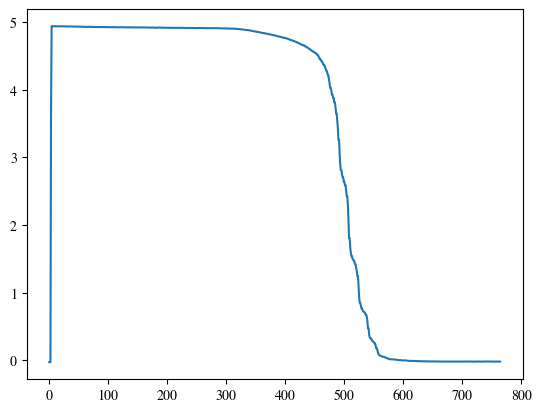

In [9]:
plt.plot(rbeamifinal)

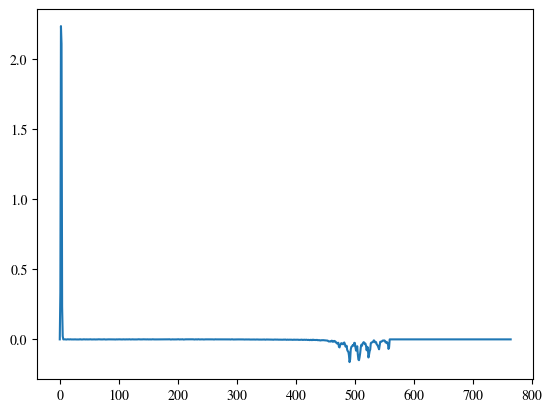

In [9]:
plt.plot(np.gradient(rbeamave))

In [12]:
htune

array([25.39999955, 25.32500069])